In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time
import neurogym as ngym


C:\Users\Mahatma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\envs\registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


# Coursework Q2 File

## Part A
### What?
For this part we need to train two AI models, a standard RNN and a a brain inspired-variation

The standard - vanilla RNN, leaky RNN, light GRU, GRU, LSTM

These can be found in lab sheets:
vanilla RNN - \\
leaky RNN - 1,3,4\\
light RNN - \\
light GRU - \\
GRU - \\
LSTM - 3\\

### How to write
We need to explain this with equations and scematic diagrams, comparing the differences between the two.


Using leakyRNN code from lab sheet 3


#### Load Perceptual Decision Making data

### Variable center

In [24]:
def general_train_model(net, dataset,lr = 0.01, n_steps=2000, verbose=False):
    """Simple helper function to train the model.

    Args:
        net: a pytorch nn.Module module
        dataset: a dataset object that when called produce a (input, target output) pair

    Returns:
        net: network object after training
    """
    env = dataset.env
    env.reset(no_step=True)

    # Use Adam optimizer
    optimizer = optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    loss_values = []
    acc_values = []
    running_loss = 0
    running_acc = 0
    start_time = time.time()
    print_step = 100
    # Loop over training batches
    print('Training network...')
    for i in range(n_steps):
        # Generate input and target, convert to pytorch tensor
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        # boiler plate pytorch training:
        optimizer.zero_grad()   # zero the gradient buffers
        output,_ = net(inputs) 
        # Reshape to (SeqLen x Batch, OutputSize)
        output = output.view(-1, output_size)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()    # Does the update

        # Compute the running loss and accuracy every 100 steps
        running_loss += loss.item()
        running_acc += (output.argmax(dim=1) == labels).float().mean().item()
        if i % print_step == print_step-1:
            average_loss = running_loss/ print_step
            average_acc = running_acc / print_step
            if average_loss > 1:
                print('Loss spike at step {}, value {:0.4f}'.format(i+1,average_loss))

            if verbose:
                print('Step {}, Loss {:0.4f}, Acc {:0.4f}, Time {:0.1f}s'.format(
                    i+1, average_loss, average_acc , time.time() - start_time))
            loss_values.append(average_loss)
            acc_values.append(average_acc)
            running_loss = 0
            running_acc = 0
    print('Final Step {}, Loss {:0.4f}, Acc {:0.4f}, Time {:0.1f}s'.format(
                    i+1, average_loss, average_acc , time.time() - start_time))
    return net, loss_values, acc_values

In [4]:
from PlainLeaky import Plain_RNNNet
from EI_model import EI_Net
from PlainNoisyLeaky import Plain_Noisy_RNNNet

In [62]:
# Environment
task_no = 2
# task = 'PerceptualDecisionMaking-v0' # Task 1
task = 'HierarchicalReasoning-v0' # Task 2
if task == 'PerceptualDecisionMaking-v0':
    timing = {
        'fixation': ('choice', (50, 100, 200, 400)),
        'stimulus': ('choice', (100, 200, 400, 800)),
    }
    kwargs = {'dt': 20, 'timing': timing}
elif task == 'HierarchicalReasoning-v0':
    kwargs = {'dt': 20, 'timing': {'stimulus': 1000}}
    
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env

inputs, target = dataset()
inputs = torch.from_numpy(inputs).type(torch.float)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

C:\Users\Mahatma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
C:\Users\Mahatma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
C:\Users\Mahatma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [63]:
# Instantiate the network and print information
hidden_size = 128
learning_rate = 0.01
train_len = 3000


leaky_net = Plain_RNNNet(input_size, hidden_size, output_size,dt=env.dt, sigma_rec=0.15)
EI_net = EI_Net(input_size, hidden_size, output_size,dt=env.dt, sigma_rec=0.15)
noisy_net = Plain_Noisy_RNNNet(input_size, hidden_size, output_size,dt=env.dt, sigma_rec=0.15)


leaky_net,leaky_loss_values, leaky_acc_values = general_train_model(leaky_net, dataset, lr = learning_rate, n_steps = train_len, verbose = False)
EI_net,EI_loss_values, EI_acc_values = general_train_model(EI_net, dataset, lr = learning_rate, n_steps = train_len,verbose = False)
noisy_net,noisy_loss_values, noisy_acc_values = general_train_model(noisy_net, dataset, lr = learning_rate, n_steps = train_len,verbose = False)

Training network...
Final Step 3000, Loss 0.3029, Acc 0.7769, Time 138.3s
Training network...
Final Step 3000, Loss 0.3066, Acc 0.7724, Time 233.1s
Training network...
Final Step 3000, Loss 0.3108, Acc 0.7832, Time 156.4s


In [75]:
# Reset environment
def test_model(net, dataset):
    env = dataset.env
    env.reset(no_step=True)

    # Initialize variables for logging
    perf = 0
    activity_dict = {}  # recording activity
    trial_infos_plain = {}  # recording trial information

    num_trial = 200
    for i in range(num_trial):
        # Neurogym boiler plate
        # Sample a new trial
        trial_info = env.new_trial()
        # Observation and groud-truth of this trial
        ob, gt = env.ob, env.gt
        # Convert to numpy, add batch dimension to input
        inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)

        # Run the network for one trial
        # inputs (SeqLen, Batch, InputSize)
        # action_pred (SeqLen, Batch, OutputSize)
        action_pred, rnn_activity = leaky_net(inputs) # to-do

        # Compute performance
        # First convert back to numpy
        action_pred = action_pred.detach().numpy()[:, 0, :]
        # Read out final choice at last time step
        choice = np.argmax(action_pred[-1, :])
        # Compare to ground truth
        correct = choice == gt[-1]

        # Record activity, trial information, choice, correctness
        rnn_activity = rnn_activity[:, 0, :].detach().numpy()
        activity_dict[i] = rnn_activity
        trial_infos_plain[i] = trial_info  # trial_info is a dictionary
        trial_infos_plain[i].update({'correct': correct})

    # # Print information for sample trials
    # for i in range(5):
    #     print('Trial ', i, trial_infos_plain[i])

    print('Average performance', np.mean([val['correct'] for val in trial_infos_plain.values()]))

In [77]:
test_model(leaky_net, dataset)
test_model(EI_net, dataset)
test_model(noisy_net, dataset)

Average performance 0.535
Average performance 0.46
Average performance 0.505


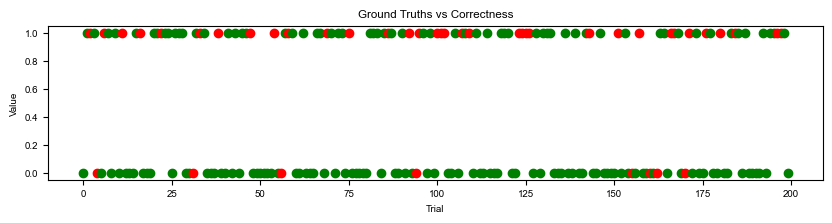

In [9]:
# Extract ground truths and correctness from trial_infos
ground_truths = [info['ground_truth'] for info in trial_infos_plain.values()]
correctness = [info['correct'] for info in trial_infos_plain.values()]

# Plot ground truths against correctness
plt.figure(figsize=(10, 2))
for i,val in enumerate(ground_truths):
    if correctness[i] == 1:
        plt.plot(i,val, 'o', color='green')
    else:
        plt.plot(i,val, 'o', color='red')
plt.xlabel('Trial')
plt.ylabel('Value')
plt.title('Ground Truths vs Correctness')
plt.show()


In [ ]:
# @title Run the network post-training and record neural activity

env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})
perf = 0
num_trial = 500
activity_dict = {}
trial_infos = {}
stim_activity = [[], []]  # response for ground-truth 0 and 1
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity = net(inputs)

    # Compute performance
    action_pred = action_pred.detach().numpy()
    choice = np.argmax(action_pred[-1, 0, :])
    correct = choice == gt[-1]

    # Log trial info
    trial_info = env.trial
    trial_info.update({'correct': correct, 'choice': choice})
    trial_infos[i] = trial_info

    # Log stimulus period activity
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity

    # Compute stimulus selectivity for all units
    # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
    rnn_activity = rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]
    stim_activity[env.trial['ground_truth']].append(rnn_activity)

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))


Average performance 0.828


#### Plain + noise

In [ ]:
# Reset environment
env = dataset.env
env.reset(no_step=True)

# Initialize variables for logging
perf = 0
activity_dict = {}  # recording activity
trial_infos_noisy = {}  # recording trial information

num_trial = 200
for i in range(num_trial):
    # Neurogym boiler plate
    # Sample a new trial
    trial_info = env.new_trial()
    # Observation and groud-truth of this trial
    ob, gt = env.ob, env.gt
    # Convert to numpy, add batch dimension to input
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)

    # Run the network for one trial
    # inputs (SeqLen, Batch, InputSize)
    # action_pred (SeqLen, Batch, OutputSize)
    action_pred, rnn_activity = Noisy_net(inputs) # to-do

    # Compute performance
    # First convert back to numpy
    action_pred = action_pred.detach().numpy()[:, 0, :]
    # Read out final choice at last time step
    choice = np.argmax(action_pred[-1, :])
    # Compare to ground truth
    correct = choice == gt[-1]

    # Record activity, trial information, choice, correctness
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity
    trial_infos_noisy[i] = trial_info  # trial_info is a dictionary
    trial_infos_noisy[i].update({'correct': correct})
    

# Print information for sample trials
for i in range(5):
    print('Trial ', i, trial_infos_noisy[i])

print('Average performance', np.mean([val['correct'] for val in trial_infos_noisy.values()]))

Trial  0 {'ground_truth': 0, 'coh': 12.8, 'correct': True}
Trial  1 {'ground_truth': 1, 'coh': 0.0, 'correct': False}
Trial  2 {'ground_truth': 0, 'coh': 6.4, 'correct': True}
Trial  3 {'ground_truth': 1, 'coh': 25.6, 'correct': True}
Trial  4 {'ground_truth': 1, 'coh': 0.0, 'correct': False}
Average performance 0.85


### Comparing learning curves

### Plotting functions
#### Combined plots

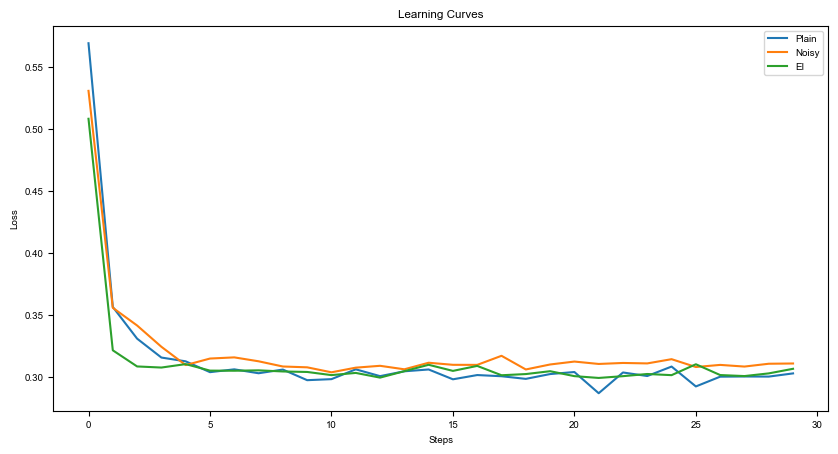

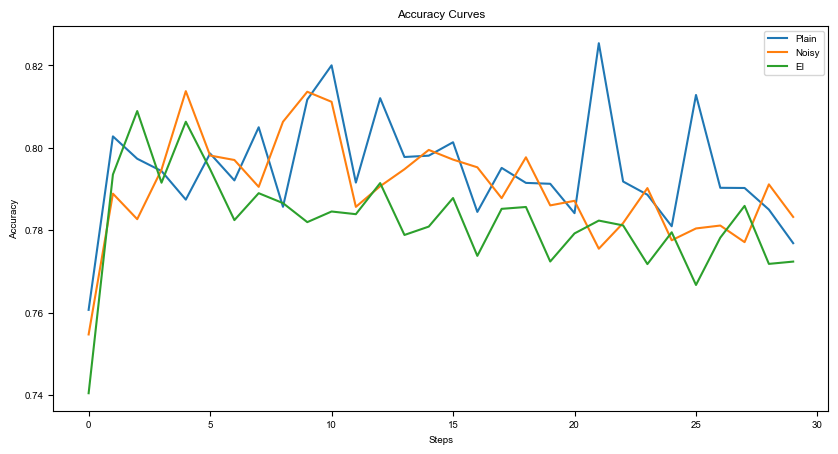

In [64]:
plt.figure(figsize=(10,5))
plt.title("Learning Curves")
plt.plot(leaky_loss_values, label='Plain')
plt.plot(noisy_loss_values, label='Noisy')
plt.plot(EI_loss_values, label='EI')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.savefig('graphs/all_loss.svg')

plt.show()

plt.figure(figsize=(10,5))
plt.title("Accuracy Curves")
plt.plot(leaky_acc_values, label='Plain')
plt.plot(noisy_acc_values, label='Noisy')
plt.plot(EI_acc_values, label='EI')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('graphs/all_acc.svg')
plt.show()

#### Seperate Plots

In [65]:
def loss_accuracy(loss,accuracy, name = ''):
    plt.figure()
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    
    ax[0].plot(loss)
    ax[0].set_title('Loss')
    ax[0].set_xticklabels(np.arange(len(loss)) * 100)
    ax[0].set_xlabel('Steps')
    # ax[0].set_ylim(0.05,0.1)
    ax[1].plot(accuracy)
    ax[1].set_title('Accuracy')
    ax[1].set_xticklabels(np.arange(len(accuracy)) * 100)
    ax[1].set_xlabel('Steps')

    plt.savefig(f'graphs/loss_accuracy_{name}.svg')
    plt.show()

C:\Users\Mahatma\AppData\Local\Temp\ipykernel_27912\293439057.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(np.arange(len(loss)) * 100)
C:\Users\Mahatma\AppData\Local\Temp\ipykernel_27912\293439057.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(np.arange(len(accuracy)) * 100)


<Figure size 640x480 with 0 Axes>

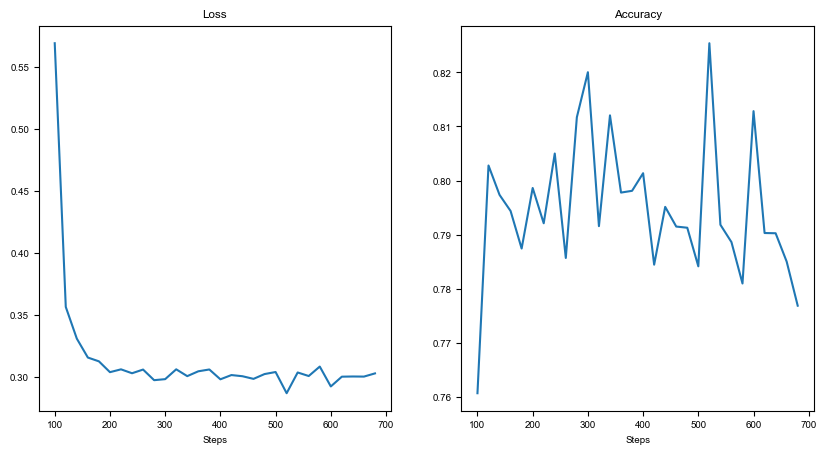

<Figure size 640x480 with 0 Axes>

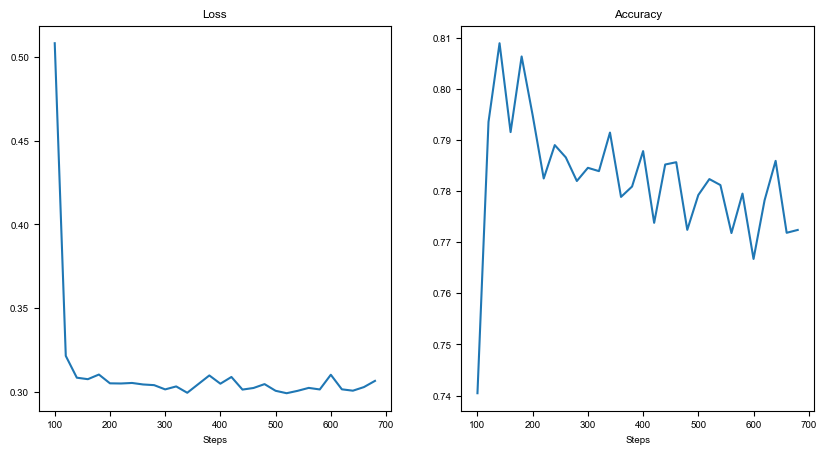

<Figure size 640x480 with 0 Axes>

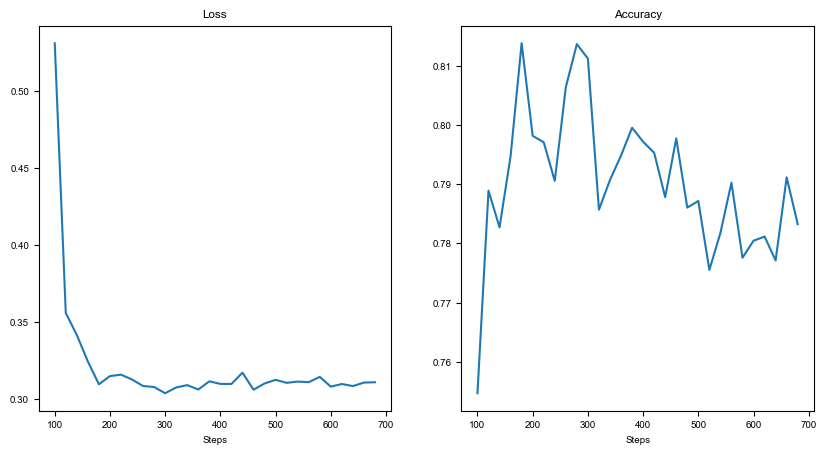

In [66]:
loss_accuracy(leaky_loss_values,leaky_acc_values,name='leaky')
loss_accuracy(EI_loss_values,EI_acc_values,name='EI')
loss_accuracy(noisy_loss_values,noisy_acc_values,name='noisy')

### Fixed Point finding

In [67]:
# Add the path to the directory containing FixedPointFinderTorch.py
import sys
sys.path.append('../fixed-point-finder')

# Import the FixedPointFinderTorch class
from FixedPointFinderTorch import FixedPointFinderTorch as FixedPointFinder
import torch
class FixedPointRNNWrapper(torch.nn.Module):
    def __init__(self, rnn, batch_first=False):
        super(FixedPointRNNWrapper, self).__init__()
        self.rnn = rnn
        self.batch_first = batch_first  # Ensure this matches your RNN's setting

    def forward(self, input, hidden):
        # Squeeze the extra dimension from hidden state
        # Hidden shape transforms from [1, batch_size, hidden_size] to [batch_size, hidden_size]
        hidden = hidden.squeeze(0)

        # EI-RNN expects inputs of shape [seq_len, batch_size, input_size]
        # Since we have seq_len=1, input shape is already correct

        # Forward pass through your EI-RNN
        output, hidden = self.rnn(input, hidden)

        # Unsqueeze hidden to match FixedPointFinder's expectation
        # Hidden shape transforms from [batch_size, hidden_size] to [1, batch_size, hidden_size]
        hidden = hidden.unsqueeze(0)

        # Return None for output as per FixedPointFinder's requirement
        return None, hidden
    

In [68]:
def run_fixed_point(net):    
    # Instantiate the FixedPointRNNWrapper with the EI-RNN model from Net
    rnn_model_fixed_point = FixedPointRNNWrapper(net.rnn, batch_first=False)

    # Instantiate FixedPointFinder with the wrapped EI-RNN model
    finder = FixedPointFinder(rnn_model_fixed_point)

    # Define initial conditions and inputs for fixed-point analysis
    initial_conditions = torch.randn(10, net.rnn.hidden_size) # 10 random initial hidden states (one for each hidden unit)
    inputs = torch.zeros(10, net.input_size)  # Zero input for each initial condition

    # Convert initial conditions and inputs to NumPy arrays for FixedPointFinder
    init_hidden_np = initial_conditions.cpu().numpy()
    inputs_np = inputs.cpu().numpy()

    # Find fixed points (CHeck FixedPointFinder documentation)
    fixed_points_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)

    # Unpack the returned tuple
    fps = fixed_points_result[0]  # Assuming FixedPoints object is the first element

    # Access fixed points
    fixed_points = fps.xstar  # Now you can access the xstar attribute
    return fixed_points

In [69]:
leaky_fixed_points = run_fixed_point(leaky_net)
EI_fixed_points = run_fixed_point(EI_net)
noisy_fixed_points = run_fixed_point(noisy_net)


Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		1035 iters
		q = 1.55e-13 +/- 3.06e-13
		dq = 8.38e-15 +/- 7.70e-15
		learning rate = 1.66e-01
		avg iter time = 2.21e-03 sec
	Identified 1 unique fixed points.
		initial_states: 0 outliers detected (of 10).
		fixed points: 0 outliers detected (of 1).
	Computing recurrent Jacobian at 1 unique fixed points.
	Computing input Jacobian at 1 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.


Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Maximum iteration count reached. Terminating.
		5000 iters
		q = 9.56e-02 +/- 2.26e-02
		dq = 3.17e-02 +/- 1.28e-02
		learni

### PCA Analysis

In [70]:
def run_for_neural(net):    
    env.reset(no_step=True)
    env.timing.update({'fixation': ('constant', 500),
                    'stimulus': ('constant', 500)})
    perf = 0
    num_trial = 500
    activity_dict = {}
    trial_infos = {}
    stim_activity = [[], []]  # response for ground-truth 0 and 1
    for i in range(num_trial):
        env.new_trial()
        ob, gt = env.ob, env.gt
        inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
        action_pred, rnn_activity = net(inputs)

        # Compute performance
        action_pred = action_pred.detach().numpy()
        choice = np.argmax(action_pred[-1, 0, :])
        correct = choice == gt[-1]

        # Log trial info
        trial_info = env.trial
        trial_info.update({'correct': correct, 'choice': choice})
        trial_infos[i] = trial_info

        # Log stimulus period activity
        rnn_activity = rnn_activity[:, 0, :].detach().numpy()
        activity_dict[i] = rnn_activity

        # Compute stimulus selectivity for all units
        # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
        rnn_activity = rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]
        stim_activity[env.trial['ground_truth']].append(rnn_activity)

    return activity_dict,trial_infos
    # print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))

In [71]:
leaky_activity_dict,leaky_trial_infos = run_for_neural(leaky_net)
EI_activity_dict,EI_trial_infos = run_for_neural(EI_net)
noisy_activity_dict,noisy_trial_infos = run_for_neural(noisy_net)

KeyError: 'stimulus'

In [ ]:
# Import necessary libraries
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

def plot_pca(activity_dict, trial_infos, num_trial, plot_until_time, name = ''):
    num_trial = 500  # Number of trials to analyse

    ### Play with different values here to understand the dynamics
    plot_until_time = 70



    # Concatenate activity data across all trials for PCA
    activity = np.concatenate([activity_dict[i] for i in range(num_trial)], axis=0)
    print('Shape of the neural activity (Time points, Neurons):', activity.shape)

    # Initialize PCA and fit it on the activity data
    pca = PCA(n_components=2) # Using 2 components for visualization
    pca.fit(activity)
    activity_pc = pca.transform(activity)   # Transform to lower dimensions (2D) - hint ".transform" could he helpful
    print('Shape of the projected activity (Time points, PCs):', activity_pc.shape)

    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

    # Plot all trials in ax1 and fewer trials in ax2 for clarity
    for i in range(100):
        # Transform and plot each trial
        activity_pc = pca.transform(activity_dict[i])  # Project each trial's activity

        # Color by ground truth
        trial = trial_infos[i]
        if task_no == 1:
            color = 'red' if trial['ground_truth'] == 0 else 'blue'

        elif task_no == 2:
            color = 'red' if trial['correct'] == 0 else 'blue'

        ax1.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)
        if i < 3:  # Fewer trials in ax2 for clear visualization
            ax2.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)

        # Indicate trial start with a different marker
        ax1.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')

    # Setting labels and titles for clarity
    ax1.set_title('100 Trials')
    ax2.set_title('3 Trials')
    ax1.set_xlabel('PC 1')
    ax1.set_ylabel('PC 2')

    plt.savefig(f'graphs/pca_{name}.svg')

    plt.tight_layout()
    plt.show()


Shape of the neural activity (Time points, Neurons): (27500, 128)
Shape of the projected activity (Time points, PCs): (27500, 2)


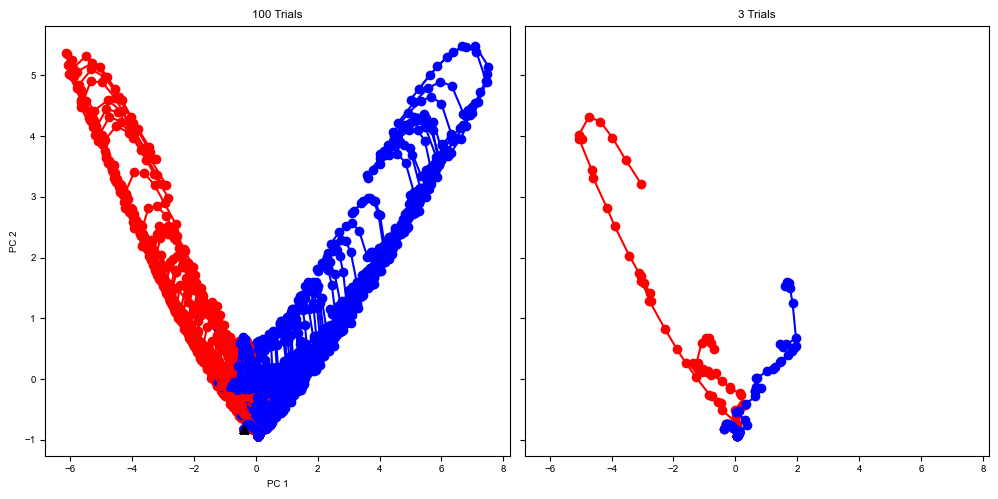

Shape of the neural activity (Time points, Neurons): (27500, 128)
Shape of the projected activity (Time points, PCs): (27500, 2)


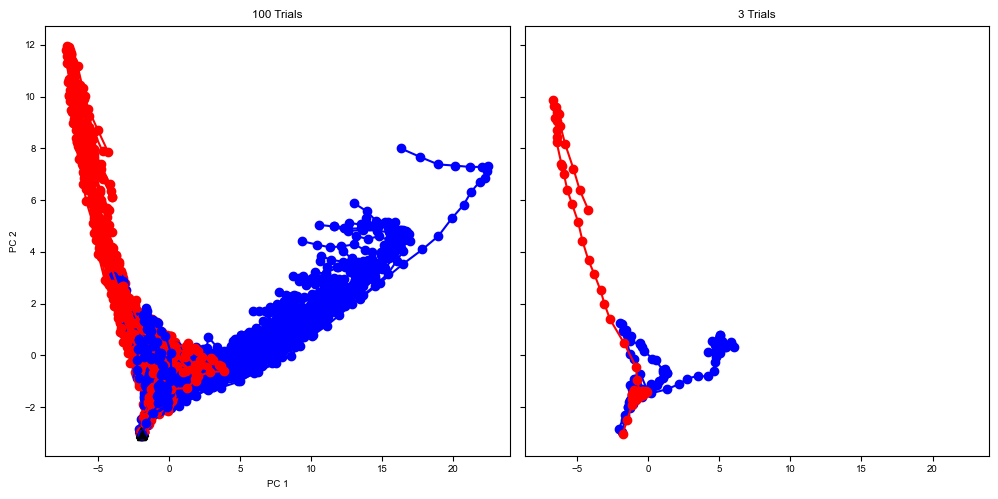

Shape of the neural activity (Time points, Neurons): (27500, 128)
Shape of the projected activity (Time points, PCs): (27500, 2)


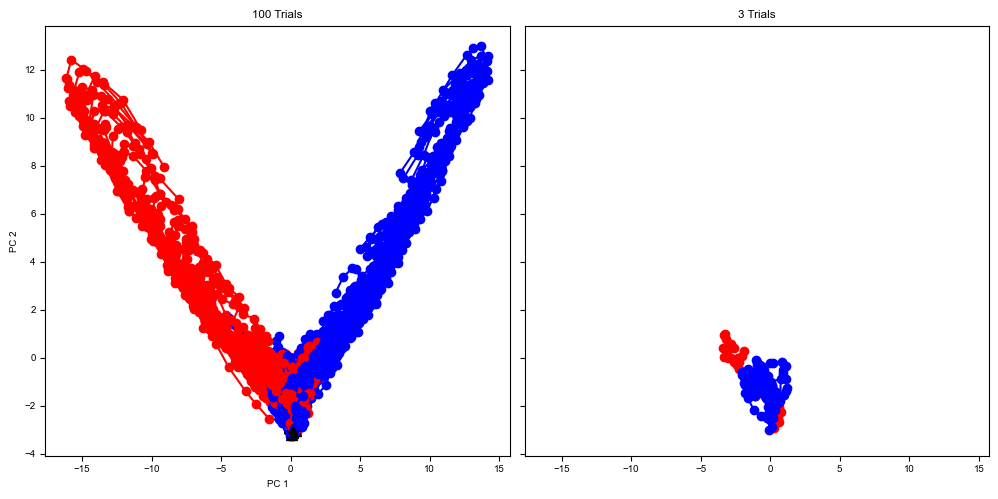

In [72]:
num_trial = 500
plot_pca(leaky_activity_dict, leaky_trial_infos, num_trial, 70, name = 'leaky')
plot_pca(EI_activity_dict, EI_trial_infos, num_trial, 70, name = 'EI')
plot_pca(noisy_activity_dict, noisy_trial_infos, num_trial, 70, name = 'noisy')

In [73]:
def plot_pca_with_fixed(activity_dict, trial_infos, fixed_points, num_trial, plot_until_time, name = ''):    
    activity_list = []
    for trial_activity in activity_dict.values():
        activity_list.append(trial_activity)  # Each trial_activity is of shape [time_steps, hidden_size]
    activity = np.vstack(activity_list)  # Concatenate along the time axis to get [total_time_steps, hidden_size]

    # Convert fixed points list to numpy array if it's not already
    fixed_points_array = np.vstack(fixed_points)  # Shape: [num_fixed_points, hidden_size]

    # Apply PCA to project fixed points and neural activity into the same space
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt

    pca = PCA(n_components=2)
    # Concatenate activity and fixed points for PCA projection
    activity_and_fp = np.concatenate([activity, fixed_points_array], axis=0)
    pca.fit(activity_and_fp)

    # Transform activity and fixed points
    activity_pc = pca.transform(activity)
    fixed_points_pc = pca.transform(fixed_points_array)

    # Plot activity and fixed points
    plt.figure(figsize=(8, 5))
    plt.scatter(activity_pc[:, 0], activity_pc[:, 1], alpha=0.3, label='Neural Activity')
    plt.scatter(fixed_points_pc[:, 0], fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title("Neural Activity and Fixed Points in PCA Space")
    plt.legend()

    plt.savefig(f'graphs/pca_fixed_points_{name}.svg')

    plt.show()

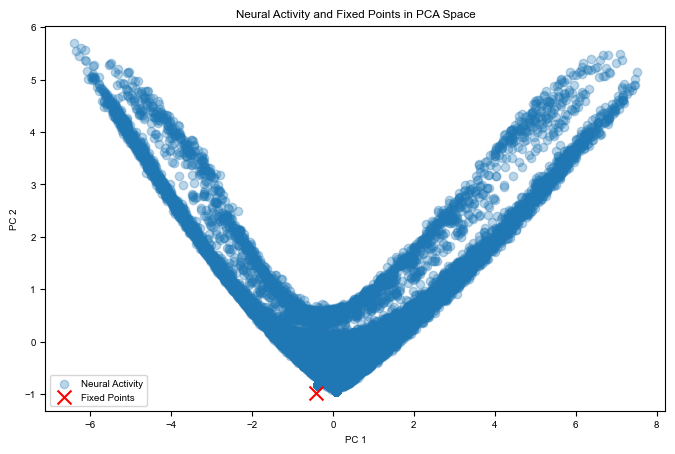

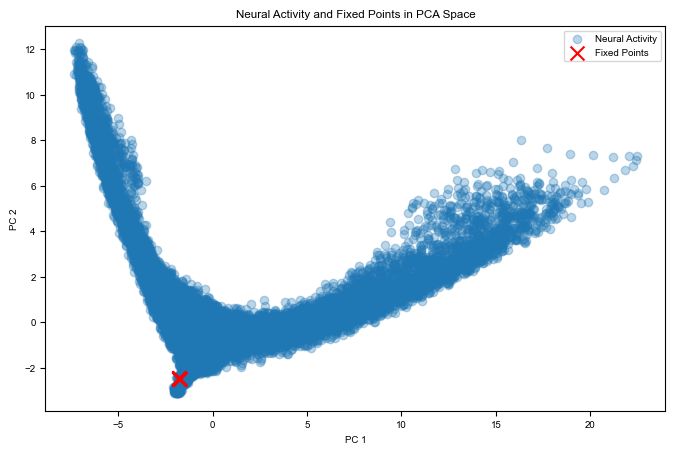

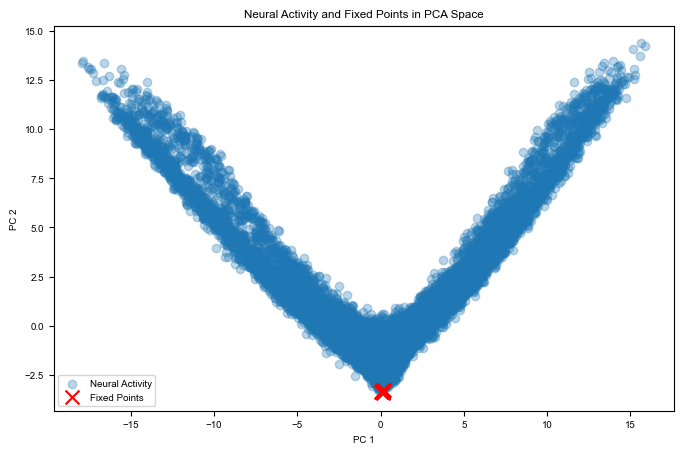

In [74]:
plot_pca_with_fixed(leaky_activity_dict, leaky_trial_infos, leaky_fixed_points, num_trial, 70, name = 'leaky')
plot_pca_with_fixed(EI_activity_dict, EI_trial_infos, EI_fixed_points, num_trial, 70, name = 'EI')
plot_pca_with_fixed(noisy_activity_dict, noisy_trial_infos, noisy_fixed_points, num_trial, 70, name = 'noisy')